<a href="https://colab.research.google.com/github/MingxiLii/Deep-Learning-Project-Template/blob/master/carfollowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch import nn, optim
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
!pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 969.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=f52b4da44817b59c983fcf9df234f31a74714343191632782e122ddcd9c55fc8
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [2]:
ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data
Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1

In [3]:
# Download data
!wget https://github.com/CHEN-HKU/data_test/blob/main/HighD_test_data.npy?raw=true --output-document=car_fol_data


--2024-04-21 16:30:00--  https://github.com/CHEN-HKU/data_test/blob/main/HighD_test_data.npy?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/Xianda-Chen/data_test/blob/main/HighD_test_data.npy?raw=true [following]
--2024-04-21 16:30:00--  https://github.com/Xianda-Chen/data_test/blob/main/HighD_test_data.npy?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Xianda-Chen/data_test/raw/main/HighD_test_data.npy [following]
--2024-04-21 16:30:00--  https://github.com/Xianda-Chen/data_test/raw/main/HighD_test_data.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Xianda-Chen/data_test/main/HighD_test_data.npy [following]
--2024-04-21 16:30:01--  

In [4]:
# load data
car_following_data=np.load('car_fol_data', allow_pickle=True)
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]
car_following_data.shape
#In the HighD dataset, the third dimension represents the data for a duration of 15 seconds. The reason for having a third dimension in the HighD dataset is that the length of each event is strictly limited to 375 data points.
#On the other hand, like in the SPMD dataset, there are only two dimensions because the data points do not have a fixed duration.

(1881, 4, 375)

In [5]:
# load data
car_following_data=np.load('car_fol_data', allow_pickle=True)
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]
car_following_data.shape
#In the HighD dataset, the third dimension represents the data for a duration of 15 seconds. The reason for having a third dimension in the HighD dataset is that the length of each event is strictly limited to 375 data points.
#On the other hand, like in the SPMD dataset, there are only two dimensions because the data points do not have a fixed duration.

(1881, 4, 375)

In [6]:
# For one event (dimenson, length)
print(np.stack(car_following_data[0]).shape)

(4, 375)


In [9]:
#split the date into train, validation, test
def split_train(data,test_ratio,val_ratio):
    np.random.seed(43)
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    val_number=int(len(data)*(test_ratio+val_ratio))
    test_indices =shuffled_indices[:test_set_size]
    val_indices=shuffled_indices[test_set_size:val_number]
    train_indices=shuffled_indices[val_number:]
    return data[train_indices],data[test_indices],data[val_indices]

train_data, test_data, val_data = split_train(car_following_data,0.3,0)

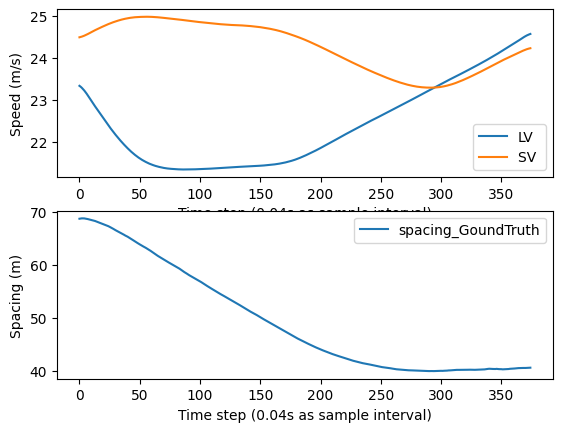

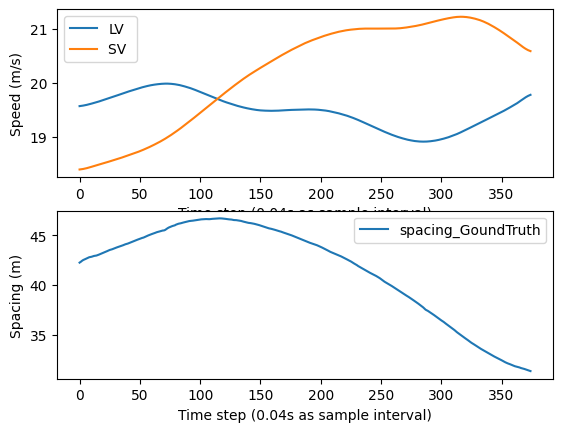

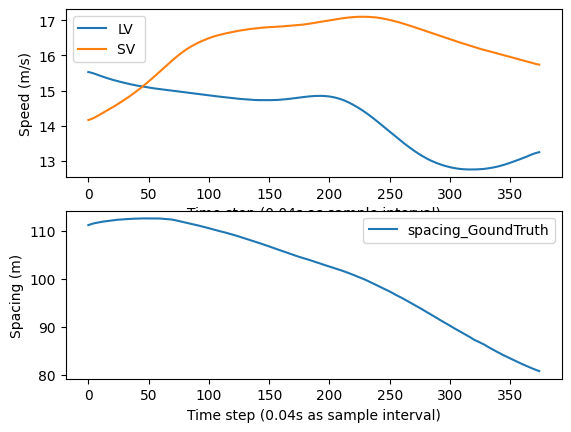

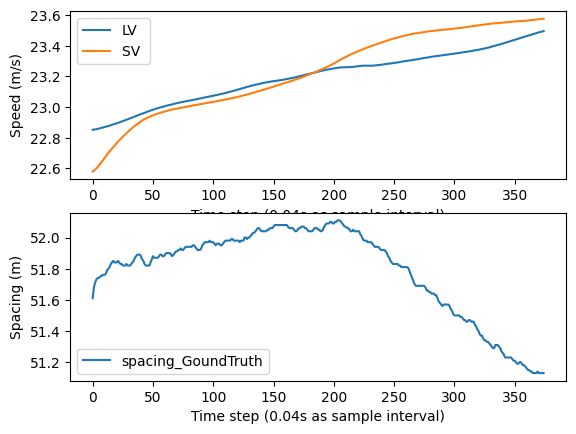

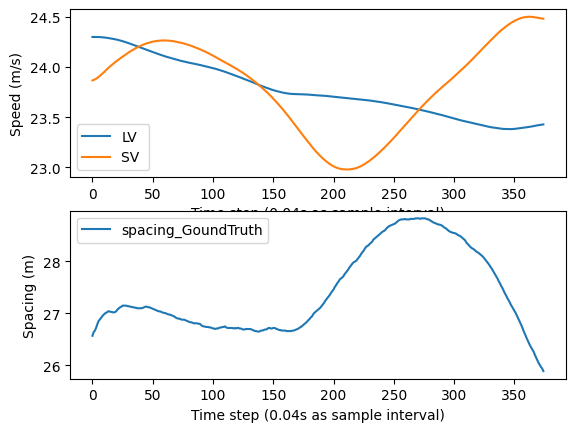

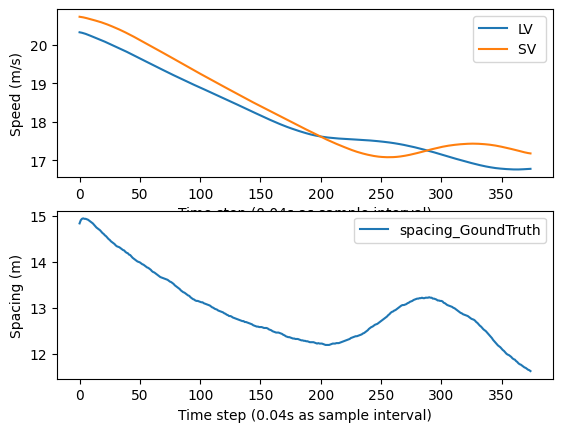

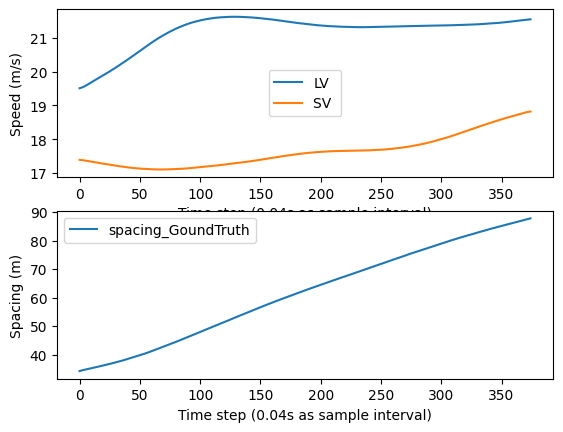

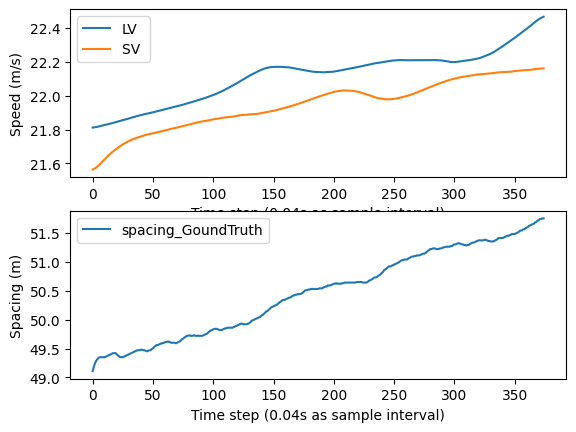

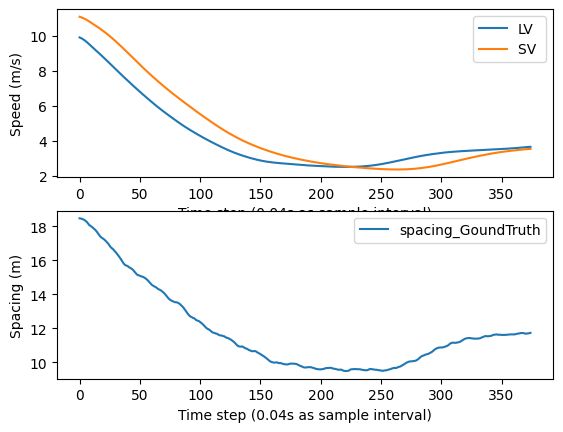

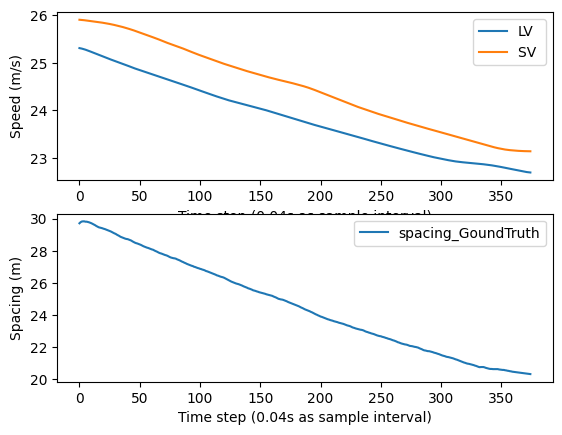

In [10]:
for num in range(10):
    spacing, svSpd_obs, relspeed, lvSpd_obs= car_following_data[num][0], car_following_data[num][1], car_following_data[num][2], car_following_data[num][3]

    plt.figure()  #
    plt.subplot(2, 1, 1)  #
    plt.plot(lvSpd_obs, label='LV')
    plt.plot(svSpd_obs, label='SV ')
    # plt.plot(relspeed, label='Relative_speed')
    plt.legend()
    # plt.ylim([0, 30])
    plt.xlabel(f'Time step ({Ts}s as sample interval)')
    plt.ylabel('Speed (m/s)')
    plt.subplot(2, 1, 2)
    plt.plot(spacing, label='spacing_GoundTruth')

    plt.legend()
    plt.xlabel('Time step (0.04s as sample interval)')
    plt.ylabel('Spacing (m)')
    plt.show()

Calibration IDM model using GA(genatical algorithmn)

In [11]:
# Define IDM model
def IDM(para, spacing, svSpd, relSpd):

    """
    Funciton that takes IDM paramters and car-following states as inputs, and output
    the acceleration for the following vehicle.

    :param para: a vector containing IDM's parameters.
        E.g., para = np.array([32.0489077 ,  0.74084102,  1.18623382,  0.87773747,  1.,2.95210611])
    :param spacing: scaler, gap between two vehicles [m].
    :param svSpd: speed of the following vehicle [m/s].
    :param relSpd: lead vehicle speed - following vehicle speed [m/s].
    :return: acceleration of the following vehicle in next step [m/s^2].
    """
    desiredSpd = para[0]  # in m/s
    desiredTimeHdw = para[1]  # in seconds
    maxAcc = para[2]  # m/s^2
    comfortAcc = para[3]  # m/s^2
    beta = para[4]
    jamSpace = para[5]  # in meters

    desiredSpacing = jamSpace + max(0, desiredTimeHdw * svSpd - svSpd * relSpd / (2 * np.sqrt(maxAcc * comfortAcc)))
    acc = maxAcc * (1 - (svSpd / desiredSpd) ** beta - (desiredSpacing / spacing) ** 2)

    return acc
def simulate_car_fol_IDM(model_fun, lvSpd, init_s, init_svSpd, para):
    """
    Simulate a car following event based on a car-following model.

    :param model_fun:
    """
    T = Ts  # data sampling interval
    svSpd_sim = []
    spacing_sim = []
    # IDM
    spacing, svSpd, relSpd = init_s, init_svSpd, lvSpd[0] - init_svSpd
    svSpd_sim.append(svSpd)
    spacing_sim.append(spacing)
    is_collision=False
    for i in range(1, len(lvSpd)):
        # calcualate next_step acceleration using IDM model
        acc = model_fun(para, spacing, svSpd, relSpd)

        # state update based on Newton's motion law
        svSpd_ = max(0.001, svSpd + acc * T)  # next step svSpd
        relSpd_ = lvSpd[i] - svSpd_
        spacing_ = spacing + T * (relSpd_ + relSpd) / 2

        # update state variables
        svSpd = svSpd_
        relSpd = relSpd_
        spacing = spacing_

        if (spacing <=0) :
            is_collision=True
            break
        # store simulation results
        svSpd_sim.append(svSpd)
        spacing_sim.append(spacing)

    return np.asarray(svSpd_sim), np.asarray(spacing_sim)


 The best solution found:
 [34.72627879  0.1768883   0.24772432  0.75924304  1.23276639  6.64656276]

 Objective function:
 5.291387741120245


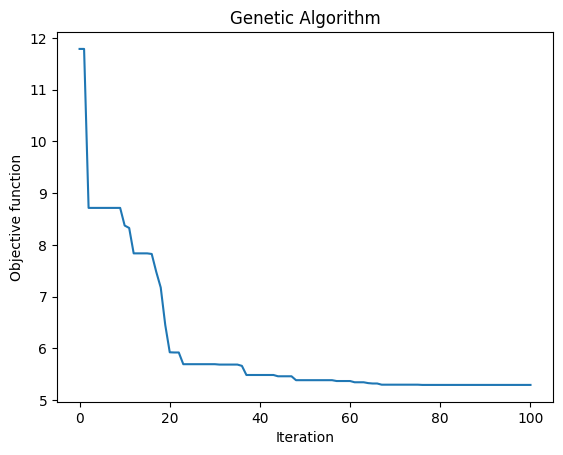

Estimated parameters: [34.72627879  0.1768883   0.24772432  0.75924304  1.23276639  6.64656276]


In [12]:
# start calibrating using GA
epoch = 1
# paticular in colab cause the limited computation resource, we only take number of 5 (num_lenth) for calibration
num_lenth = 5
def evaluate_set( svSpd_gt_set, spacing_gt_set,lvSpd_obs_set,para):
    error = 0
    for t in range(len(spacing_gt_set)):
        #IDM
        INIT_S=spacing_gt_set[t][0]
        INIT_SVSPD=svSpd_gt_set[t][0]
        lvSpd_obs=lvSpd_obs_set[t]
        speeding_sim, spacing_sim = simulate_car_fol_IDM(IDM, lvSpd_obs, INIT_S, INIT_SVSPD, para)
        remain_len = len(spacing_gt_set[t]) - len(spacing_sim)
        PENALTY_CONST = 100
        error += np.mean((spacing_sim - spacing_gt_set[t][:len(spacing_sim)]) ** 2) + remain_len*PENALTY_CONST #spacing_gt
    return error/len(spacing_gt_set)

for iter_number in range(epoch):
    svSpd_obs_set=train_data[:, 1]
    space_obs_set=train_data[:, 0]
    lvSpd_obs_set=train_data[:, -1]

    fitness_func_set = partial(evaluate_set,svSpd_obs_set[0:num_lenth] , space_obs_set[0:num_lenth],lvSpd_obs_set[0:num_lenth])

    # TODO: adjust these paramters to have lower errors.
    algorithm_param = {'max_num_iteration': 100, \
                       'population_size': 100, \
                       'mutation_probability': 0.2, \
                       'elit_ratio': 0.01, \
                       'crossover_probability': 0.3, \
                       'parents_portion': 0.3, \
                       'crossover_type': 'uniform', \
                       'max_iteration_without_improv': 100}

    varbound = np.array(
        [[1., 41.66666667],
         [0.1, 5.],
         [0.1, 5.],
         [0.1, 5.],
         [1., 10.],
         [0.1, 10.]]
    )
    model = ga(function=fitness_func_set, dimension=len(varbound), variable_type='real',
               variable_boundaries=varbound,
               algorithm_parameters=algorithm_param,function_timeout = 20
               )

    model.run()
    plt.close('all')
    print(f'Estimated parameters: {model.best_variable}')


In [13]:
# evaluate the parameter of IDM
def simulate_car_fol_IDM_test(model_fun, lvSpd, init_s, init_svSpd, para):
    """
    Simulate a car following event based on a car-following model.

    :param model_fun:
    """
    T = Ts  # data sampling interval

    svSpd_sim = []
    spacing_sim = []
    # IDM
    spacing, svSpd, relSpd = init_s, init_svSpd, lvSpd[0] - init_svSpd
    svSpd_sim.append(svSpd)
    spacing_sim.append(spacing)

    is_collision=False
    for i in range(1, len(lvSpd)):
        # calcualate next_step acceleration using IDM model
        acc = model_fun(para, spacing, svSpd, relSpd)

        # state update based on Newton's motion law
        svSpd_ = max(0.001, svSpd + acc * T)  # next step svSpd
        relSpd_ = lvSpd[i] - svSpd_
        spacing_ = spacing + T * (relSpd_ + relSpd) / 2

        # update state variables
        svSpd = svSpd_
        relSpd = relSpd_
        spacing = spacing_
        svSpd_sim.append(svSpd)
        spacing_sim.append(spacing)

    return np.asarray(svSpd_sim), np.asarray(spacing_sim)

def evaluate_set_test( svSpd_gt_set, spacing_gt_set,lvSpd_obs_set,para):
    error = 0
    collision = 0
    for t in range(len(spacing_gt_set)):
        #IDM
        INIT_S=spacing_gt_set[t][0]
        INIT_SVSPD=svSpd_gt_set[t][0]
        lvSpd_obs=lvSpd_obs_set[t]
        _, spacing_sim = simulate_car_fol_IDM_test(IDM, lvSpd_obs, INIT_S, INIT_SVSPD, para)

        error += np.mean((spacing_sim - spacing_gt_set[t][:len(spacing_sim)]) ** 2)
    collision_rate =   collision / len(spacing_gt_set)
    return error/len(spacing_gt_set) , collision_rate

val_error, rate =evaluate_set_test( svSpd_obs_set , space_obs_set,lvSpd_obs_set,model.best_variable)

# val_error=evaluate_set( svSpd_obs_set , space_obs_set,lvSpd_obs_set,model.best_variable)
print('val_error=',val_error)
print('collision_rate=',rate)

val_error= 30.945136569281043
collision_rate= 0.0


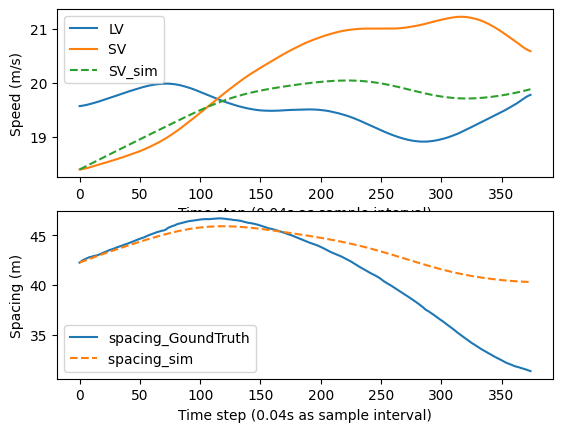

In [14]:
# Simulate IDM with calibrated para
para =[31.63398677,  0.8485575 ,  0.35958698 , 0.39194875 , 2.89009438 , 3.4968872 ] # HighD
num = 1
space_obs_dhw, svSpd_obs, relspeed, lvSpd_obs= car_following_data[num][0], car_following_data[num][1], car_following_data[num][2], car_following_data[num][3]
speed_sim, spacing_sim = simulate_car_fol_IDM_test(IDM, lvSpd_obs, space_obs_dhw[0], svSpd_obs[0], para)
plt.figure()  #
plt.subplot(2, 1, 1)  #
plt.plot(lvSpd_obs, label='LV')
plt.plot(svSpd_obs, label='SV ')
plt.plot(speed_sim,'--', label='SV_sim')
plt.legend()
# plt.ylim([0, 30])
plt.xlabel('Time step (0.04s as sample interval)')
plt.ylabel('Speed (m/s)')
plt.subplot(2, 1, 2)
plt.plot(space_obs_dhw, label='spacing_GoundTruth')
#     plt.plot(space_obs_filtered,'--' ,label='spacing_filtered')
plt.plot(spacing_sim,'--', label='spacing_sim ')
plt.legend()
plt.xlabel('Time step (0.04s as sample interval)')
plt.ylabel('Spacing (m)')
plt.show()

Define NN and lstm models

In [17]:
max_len = 375 # for HighD dataset for others are 150

class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, split: str, max_len = max_len):
        if split == 'train':
            self.data = train_data
        elif split == 'test':
            self.data = test_data
        elif split == 'validation':
            self.data = val_data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):

        event = self.data[idx]
        sv =  event[1][:self.max_len]
        lv = event[3][:self.max_len]
        spacing = event[0][:self.max_len]
        relSpeed = event[2][:self.max_len]
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        acc_label = np.diff(sv)/Ts
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

# Define data-driven car-following models
class nn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 256):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh(),
            )

    def forward(self, x):
        out = ACC_LIMIT*self.encoder(x)
        return out

class lstm_model(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def __init__(self, input_size = 3, hidden_size = 16, lstm_layers = 1, dropout = 0.1):
        super(lstm_model, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first = False, dropout = dropout)
        self.linear = nn.Linear(hidden_size, 1)

        nn.init.normal_(self.linear.weight, 0, .02)
        nn.init.constant_(self.linear.bias, 0.0)

    def forward(self, src):
        # src in the shape seq_len, B, d
        enc_x, (h_n, c_n) = self.encoder(src)

        if len(h_n.shape) == 3:
            h_n = h_n[-1] # taking the last layer hidden state

        out = self.linear(h_n)
        out = torch.tanh(out)*ACC_LIMIT
        return out

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


cpu
---


  0%|          | 0/20 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1| Train Loss: 0.1249306


  5%|▌         | 1/20 [00:24<07:45, 24.49s/it]

Epoch: 2| Train Loss: 0.1149644


 10%|█         | 2/20 [00:55<08:33, 28.53s/it]

Epoch: 3| Train Loss: 0.0967139


 15%|█▌        | 3/20 [01:24<08:05, 28.54s/it]

Epoch: 4| Train Loss: 0.0902845


 20%|██        | 4/20 [01:50<07:19, 27.48s/it]

Epoch: 5| Train Loss: 0.0898665


 25%|██▌       | 5/20 [02:15<06:38, 26.56s/it]

Epoch: 6| Train Loss: 0.0889413


 30%|███       | 6/20 [02:41<06:10, 26.47s/it]

Epoch: 7| Train Loss: 0.0885315


 35%|███▌      | 7/20 [03:07<05:40, 26.23s/it]

Epoch: 8| Train Loss: 0.0887220


 40%|████      | 8/20 [03:33<05:13, 26.11s/it]

Epoch: 9| Train Loss: 0.0875626


 45%|████▌     | 9/20 [04:03<05:00, 27.33s/it]

Epoch: 10| Train Loss: 0.0871949


 50%|█████     | 10/20 [04:33<04:42, 28.30s/it]

Epoch: 11| Train Loss: 0.0876450


 55%|█████▌    | 11/20 [04:59<04:08, 27.56s/it]

Epoch: 12| Train Loss: 0.0882225


 60%|██████    | 12/20 [05:24<03:35, 26.88s/it]

Epoch: 13| Train Loss: 0.0875829


 65%|██████▌   | 13/20 [05:50<03:05, 26.45s/it]

Epoch: 14| Train Loss: 0.0868997


 70%|███████   | 14/20 [06:16<02:38, 26.44s/it]

Epoch: 15| Train Loss: 0.0871748


 75%|███████▌  | 15/20 [06:42<02:10, 26.14s/it]

Epoch: 16| Train Loss: 0.0862139


 80%|████████  | 16/20 [07:07<01:43, 25.97s/it]

Epoch: 17| Train Loss: 0.0863865


 85%|████████▌ | 17/20 [07:33<01:17, 25.79s/it]

Epoch: 18| Train Loss: 0.0861088


 90%|█████████ | 18/20 [07:58<00:51, 25.78s/it]

Epoch: 19| Train Loss: 0.0869807


 95%|█████████▌| 19/20 [08:24<00:25, 25.68s/it]

Epoch: 20| Train Loss: 0.0854277


100%|██████████| 20/20 [08:49<00:00, 26.46s/it]


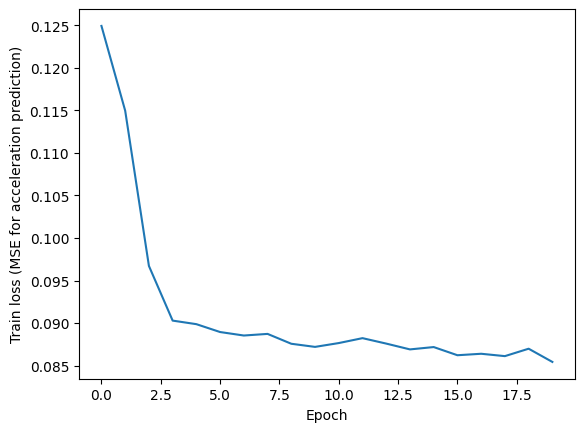

In [20]:
# Train
train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
dataset = 'HighD'
model_type = 'lstm'
batch_size = 32
total_epochs = 20
train_dataset = ImitationCarFolData(split = 'train')
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)

validation_dataset = ImitationCarFolData(split = 'validation')
validation_loader = DataLoader(
        validation_dataset ,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)

test_dataset = ImitationCarFolData(split = 'test')
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

his_horizon = 10# number of time steps as history data
lr = 1e-3 # learning rate
save = f'{model_type}_{dataset}.pt'

if model_type == 'nn':
    model = nn_model(input_size = his_horizon*3).to(device)
elif model_type == 'lstm':
    model = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm

model_optim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss_his = []
test_error_his = []
validation_error_his = []
best_train_loss = None
best_validation_loss = None


print("---")
for epoch in tqdm(range(total_epochs)):
    train_losses = []
    validation_losses = []
    model.train()
    for i, item in enumerate(train_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        x_data, y_data = item['inputs'], item['label']
        # Put T into the first dimension, B, T, d -> T, B, d
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

        y_pre = torch.zeros(T - his_horizon, B).to(device)
        y_label = y_data[his_horizon:]

        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn':
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data

            acc_pre = model(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre

        loss = criterion(y_pre, y_label)

        model_optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        model_optim.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    train_loss_his.append(train_loss)
    print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

    model.eval()
    error_list = []
    for i, item in enumerate(validation_loader):

        x_data, y_data = item['inputs'], item['label']
        # Put T into the first dimension, B, T, d -> T, B, d
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)
        lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)
        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
        # save a copy of x_data
        x_data_orig = x_data.clone().detach()
        y_label = y_data[his_horizon:]
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn':
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data

            acc_pre = model(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre

        validation_loss = criterion(y_pre, y_label)
        model_optim.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        model_optim.step()
        validation_losses.append(validation_loss.item())
    mean_validation_error = np.mean(validation_losses)
    if best_validation_loss is None or best_validation_loss > mean_validation_error:
        best_validation_loss = mean_validation_error
        # save the best model
        with open(save, 'wb') as f:
            torch.save(model, f)

    validation_error_his.append(mean_validation_error)
    # print("Epoch: {0}| Validation error: {1:.7f}".format(epoch + 1, mean_validation_error))


plt.plot(train_loss_his)
plt.xlabel('Epoch')
plt.ylabel('Train loss (MSE for acceleration prediction)');

In [21]:
# Testing, closed-loop prediction
# Load the best model saved
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

error_list = []

for i, item in enumerate(test_loader):

    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            # update
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    spacing_pre = x_data[..., 0]
    spacing_obs = x_data_orig[..., 0]

    error = criterion(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


mean_test_error 35.09631562232971


Text(0, 0.5, 'SV speed (m/s)')

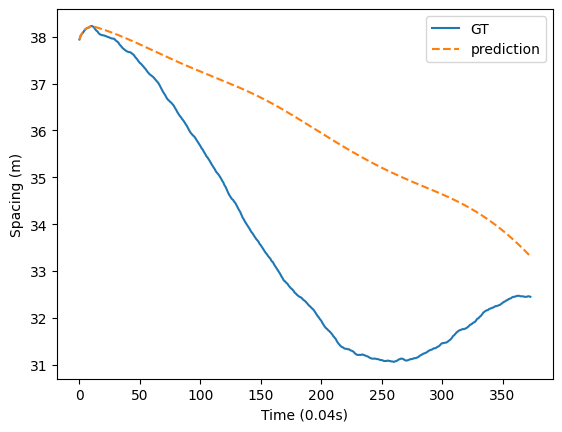

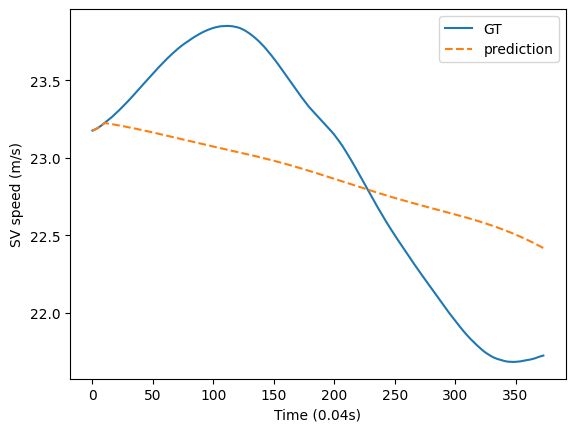

In [22]:
# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')

In [48]:
#Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.


#for test
batch_size = 1
jerk_set = []
TTC_set = []
minimum_ttc_set = []

ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]

    minimum_ttc = min(ttc)
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage

# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)
count = 0
col =0
for i, item in tqdm(enumerate(test_loader)):

    #jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []


    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            print(sv_spd_)
            MyDevice = torch.device('cuda:0')
            # sv_spd_ = torch.tensor(max(np.array(sv_spd_.detach().cpu()),[0.001]))

            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            if float(np.array(spacing_.detach().cpu()[0])) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        TTC_single.append(-spacing_ / delta_v_)
    print(acc_single)
    jerk =np.mean(np.abs(np.diff(acc_single[0].detach().numpy())/Ts))
    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = TTC_single[0].detach().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)


    # Calculating spacing error for the closed-loop simulation
    spacing_pre = x_data[..., 0]
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = criterion(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
0it [00:00, ?it/s]

tensor([24.1049, 21.5813, 14.4679, 25.7481, 15.2077, 23.2657, 24.4632, 14.1818,
        22.2868, 14.6715, 26.5152, 22.3186, 22.0697, 20.0075, 24.5788, 13.4756,
        10.6884, 33.4855, 10.4462, 21.1617, 23.7237, 22.5681, 21.1985, 23.1968,
        20.9804, 23.4895, 18.8744, 21.8393, 20.6925, 23.6842, 22.3483, 25.7012],
       grad_fn=<AddBackward0>)
tensor([24.1032, 21.5834, 14.4450, 25.7397, 15.2045, 23.2662, 24.4545, 14.1726,
        22.2869, 14.6724, 26.4946, 22.3195, 22.0603, 20.0035, 24.5800, 13.4704,
        10.6629, 33.4787, 10.4506, 21.1573, 23.7173, 22.5700, 21.2032, 23.1946,
        20.9790, 23.4866, 18.8731, 21.8401, 20.6863, 23.6774, 22.3485, 25.6913],
       grad_fn=<AddBackward0>)
tensor([24.1014, 21.5856, 14.4223, 25.7311, 15.2012, 23.2668, 24.4458, 14.1633,
        22.2870, 14.6733, 26.4739, 22.3204, 22.0508, 19.9996, 24.5812, 13.4652,
        10.6368, 33.4720, 10.4548, 21.1531, 23.7108, 22.5719, 21.2079, 23.1925,
        20.9777, 23.4839, 18.8720, 21.8409, 20.6801, 23.

1it [00:02,  2.67s/it]

[tensor([-0.0386,  0.0531, -0.5747, -0.2062, -0.0802,  0.0143, -0.2172, -0.2253,
         0.0033,  0.0208, -0.5143,  0.0234, -0.2305, -0.0965,  0.0313, -0.1260,
        -0.6290, -0.1689,  0.1117, -0.1126, -0.1566,  0.0480,  0.1173, -0.0535,
        -0.0338, -0.0719, -0.0415,  0.0205, -0.1548, -0.1698,  0.0068, -0.2479],
       grad_fn=<SqueezeBackward0>), tensor([-0.0420,  0.0535, -0.5717, -0.2105, -0.0807,  0.0136, -0.2175, -0.2284,
         0.0020,  0.0219, -0.5156,  0.0228, -0.2348, -0.0979,  0.0309, -0.1284,
        -0.6391, -0.1690,  0.1098, -0.1093, -0.1598,  0.0472,  0.1175, -0.0529,
        -0.0334, -0.0706, -0.0341,  0.0208, -0.1544, -0.1684,  0.0046, -0.2477],
       grad_fn=<SqueezeBackward0>), tensor([-0.0447,  0.0537, -0.5691, -0.2149, -0.0818,  0.0132, -0.2178, -0.2327,
         0.0015,  0.0225, -0.5160,  0.0226, -0.2376, -0.0990,  0.0305, -0.1304,
        -0.6521, -0.1696,  0.1067, -0.1059, -0.1628,  0.0467,  0.1173, -0.0524,
        -0.0328, -0.0694, -0.0273,  0.0209, -

2it [00:03,  1.85s/it]

[tensor([-0.0013, -0.1767,  0.0537, -0.0661, -0.0376,  0.0029,  0.0099, -0.1083,
         0.0291,  0.2303,  0.1218, -0.2041,  0.0090,  0.0737, -0.0341, -0.0787,
         0.0162,  0.0116,  0.0386, -0.2026, -0.0153, -0.0186, -0.0620, -0.0765,
         0.1485, -0.1533, -0.1524, -0.1047,  0.0756, -0.0331,  0.1019,  0.0036],
       grad_fn=<SqueezeBackward0>), tensor([-0.0019, -0.1790,  0.0535, -0.0637, -0.0367,  0.0028,  0.0099, -0.1060,
         0.0289,  0.2313,  0.1242, -0.2046,  0.0087,  0.0728, -0.0358, -0.0788,
         0.0157,  0.0116,  0.0382, -0.2035, -0.0156, -0.0236, -0.0631, -0.0772,
         0.1453, -0.1512, -0.1550, -0.1057,  0.0862, -0.0346,  0.1016,  0.0037],
       grad_fn=<SqueezeBackward0>), tensor([-0.0024, -0.1812,  0.0536, -0.0608, -0.0363,  0.0029,  0.0101, -0.1038,
         0.0289,  0.2329,  0.1269, -0.2049,  0.0088,  0.0704, -0.0379, -0.0786,
         0.0154,  0.0119,  0.0383, -0.2042, -0.0160, -0.0273, -0.0639, -0.0774,
         0.1416, -0.1490, -0.1576, -0.1067,  

3it [00:05,  1.55s/it]

[tensor([-0.0372,  0.0327, -0.2245,  0.0794,  0.0571,  0.0073,  0.2336, -0.1210,
        -0.1290, -0.0085,  0.0258, -0.0283, -0.0318,  0.0699,  0.0854, -0.3681,
        -0.0461, -0.0914, -0.1642, -0.1814,  0.0598, -0.1818,  0.0175,  0.0439,
         0.0167, -0.1045, -0.3757,  0.0616, -0.2511, -0.2009, -0.0085, -1.1005],
       grad_fn=<SqueezeBackward0>), tensor([-0.0343,  0.0331, -0.2242,  0.0807,  0.0571,  0.0075,  0.2330, -0.1214,
        -0.1291, -0.0086,  0.0255, -0.0300, -0.0322,  0.0706,  0.0855, -0.3676,
        -0.0483, -0.0929, -0.1648, -0.1804,  0.0604, -0.1829,  0.0170,  0.0419,
         0.0185, -0.1038, -0.3740,  0.0614, -0.2515, -0.2068, -0.0083, -1.1011],
       grad_fn=<SqueezeBackward0>), tensor([-0.0320,  0.0341, -0.2235,  0.0818,  0.0572,  0.0076,  0.2320, -0.1240,
        -0.1290, -0.0087,  0.0259, -0.0321, -0.0325,  0.0700,  0.0857, -0.3668,
        -0.0490, -0.0943, -0.1651, -0.1795,  0.0610, -0.1837,  0.0167,  0.0399,
         0.0203, -0.1032, -0.3705,  0.0614, -

4it [00:06,  1.40s/it]

[tensor([ 0.0296, -0.3872, -0.2262, -0.2606,  0.0228,  0.0249, -0.7296,  0.1168,
        -0.1694,  0.1744,  0.0924, -0.0712,  0.0147, -0.1213,  0.0244,  0.1484,
        -0.0112,  0.0653,  0.3057,  0.0402, -0.0698,  0.1874, -0.2279,  0.1547,
        -0.0986, -0.0224,  0.1168, -0.0654,  0.0450, -0.3012, -0.0141, -0.1619],
       grad_fn=<SqueezeBackward0>), tensor([ 0.0290, -0.3910, -0.2286, -0.2537,  0.0221,  0.0267, -0.7298,  0.1154,
        -0.1693,  0.1741,  0.0920, -0.0739,  0.0150, -0.1189,  0.0251,  0.1481,
        -0.0123,  0.0648,  0.3061,  0.0401, -0.0696,  0.1868, -0.2294,  0.1542,
        -0.0988, -0.0237,  0.1173, -0.0656,  0.0445, -0.2991, -0.0148, -0.1633],
       grad_fn=<SqueezeBackward0>), tensor([ 0.0283, -0.3937, -0.2308, -0.2442,  0.0217,  0.0284, -0.7292,  0.1139,
        -0.1690,  0.1749,  0.0916, -0.0789,  0.0151, -0.1158,  0.0258,  0.1464,
        -0.0128,  0.0641,  0.3053,  0.0399, -0.0692,  0.1863, -0.2316,  0.1541,
        -0.0988, -0.0247,  0.1174, -0.0661,  

5it [00:07,  1.32s/it]

[tensor([-0.0271, -0.2584,  0.0415, -0.0375, -0.0021, -0.0174, -0.1007, -0.1098,
        -0.0081,  0.0818,  0.1200, -0.0510, -0.0434, -0.1132, -0.0029,  0.0251,
        -0.0470, -0.0135, -0.1705,  0.0399,  0.0822,  0.0644, -0.3000, -0.1106,
        -0.0707, -0.0515,  0.0324, -0.0169,  0.0496,  0.2874, -0.1809, -0.0138],
       grad_fn=<SqueezeBackward0>), tensor([-0.0262, -0.2587,  0.0397, -0.0375, -0.0034, -0.0165, -0.1016, -0.1120,
        -0.0077,  0.0813,  0.1199, -0.0517, -0.0436, -0.1135,  0.0010,  0.0258,
        -0.0468, -0.0147, -0.1709,  0.0394,  0.0825,  0.0657, -0.3019, -0.1108,
        -0.0705, -0.0531,  0.0329, -0.0164,  0.0497,  0.2846, -0.1785, -0.0124],
       grad_fn=<SqueezeBackward0>), tensor([-0.0256, -0.2597,  0.0381, -0.0375, -0.0047, -0.0147, -0.1030, -0.1133,
        -0.0071,  0.0812,  0.1199, -0.0518, -0.0436, -0.1137,  0.0057,  0.0264,
        -0.0464, -0.0155, -0.1709,  0.0392,  0.0830,  0.0662, -0.3037, -0.1107,
        -0.0701, -0.0542,  0.0334, -0.0159,  

6it [00:08,  1.27s/it]

[tensor([-0.2362, -0.0370, -0.7959, -0.0450, -0.0962,  0.1557, -0.3994,  0.0195,
         0.0227, -0.3441,  0.0493, -0.1125, -0.0295,  0.2018,  0.1078,  0.1264,
        -0.0020,  0.0357, -0.2531,  0.0307, -0.2010,  0.0079, -0.3136, -0.1107,
        -0.3894, -0.0326,  0.1229, -0.0133, -0.5381,  0.0113, -0.0724,  0.0626],
       grad_fn=<SqueezeBackward0>), tensor([-0.2343, -0.0361, -0.7953, -0.0450, -0.0964,  0.1552, -0.4024,  0.0200,
         0.0209, -0.3461,  0.0492, -0.1151, -0.0295,  0.2002,  0.1061,  0.1260,
        -0.0019,  0.0354, -0.2530,  0.0314, -0.1965,  0.0074, -0.3137, -0.1126,
        -0.3758, -0.0317,  0.1218, -0.0160, -0.5381,  0.0095, -0.0733,  0.0614],
       grad_fn=<SqueezeBackward0>), tensor([-0.2326, -0.0354, -0.7956, -0.0451, -0.0960,  0.1543, -0.4042,  0.0200,
         0.0195, -0.3488,  0.0490, -0.1151, -0.0294,  0.1980,  0.1046,  0.1251,
        -0.0018,  0.0350, -0.2516,  0.0317, -0.1926,  0.0069, -0.3141, -0.1150,
        -0.3614, -0.0304,  0.1208, -0.0175, -

7it [00:09,  1.22s/it]

[tensor([-0.2677, -0.1322, -0.4021, -0.0398, -0.5879, -0.0773,  0.0054,  0.0086,
        -0.0158, -0.5246,  0.0452, -0.0641,  0.2800, -0.2558,  0.0122, -0.4179,
        -0.4692,  0.0314, -0.0800, -0.0690,  0.0937, -0.0224, -0.2052,  0.0892,
        -0.0290,  0.1953, -0.0156, -0.3250,  0.1374, -0.1834, -0.3149, -0.3216],
       grad_fn=<SqueezeBackward0>), tensor([-0.2743, -0.1325, -0.3979, -0.0435, -0.5862, -0.0775,  0.0045,  0.0084,
        -0.0159, -0.5319,  0.0443, -0.0658,  0.2796, -0.2570,  0.0130, -0.4145,
        -0.4708,  0.0309, -0.0783, -0.0666,  0.0941, -0.0225, -0.2096,  0.0892,
        -0.0277,  0.1958, -0.0160, -0.3269,  0.1368, -0.1820, -0.3051, -0.3241],
       grad_fn=<SqueezeBackward0>), tensor([-0.2790, -0.1323, -0.3925, -0.0471, -0.5848, -0.0776,  0.0031,  0.0078,
        -0.0161, -0.5385,  0.0435, -0.0674,  0.2778, -0.2591,  0.0141, -0.4108,
        -0.4723,  0.0306, -0.0760, -0.0634,  0.0940, -0.0226, -0.2143,  0.0896,
        -0.0263,  0.1944, -0.0162, -0.3275,  

8it [00:10,  1.18s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
8it [00:11,  1.38s/it]

[tensor([-0.0800, -0.1032, -0.0305, -0.0312, -0.5260, -0.1628,  0.0290, -0.0452,
        -0.0504,  0.0589, -0.0509, -0.0833,  0.0943,  0.1645, -0.1398,  0.2524,
         0.0509, -0.3737, -0.0254, -0.0415,  0.0405, -0.2491, -0.0289,  0.0236,
         0.0617, -0.0866,  0.0405, -0.0291,  0.0712, -0.0658,  0.0096, -0.0494],
       grad_fn=<SqueezeBackward0>), tensor([-0.0797, -0.1086, -0.0309, -0.0321, -0.5260, -0.1632,  0.0290, -0.0453,
        -0.0516,  0.0590, -0.0520, -0.0836,  0.0934,  0.1599, -0.1421,  0.2526,
         0.0506, -0.3720, -0.0249, -0.0391,  0.0402, -0.2495, -0.0299,  0.0231,
         0.0621, -0.0870,  0.0407, -0.0300,  0.0713, -0.0654,  0.0095, -0.0492],
       grad_fn=<SqueezeBackward0>), tensor([-0.0785, -0.1147, -0.0314, -0.0330, -0.5256, -0.1634,  0.0290, -0.0451,
        -0.0524,  0.0592, -0.0533, -0.0840,  0.0930,  0.1573, -0.1443,  0.2525,
         0.0506, -0.3697, -0.0249, -0.0372,  0.0402, -0.2490, -0.0308,  0.0229,
         0.0625, -0.0872,  0.0403, -0.0306,  